In [1]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from scipy.io import loadmat
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from statsmodels.formula.api import logit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

# MAT 388E HW3

## Q1

This is going to be an image classification problem. For this problem we are going to use [the corrected Indian Pines Dataset](https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines).

1. Download the data (both the corrected dataset and the ground-truth dataset) into a subdirectory called `data`, and ingest it as I did in [Lecture 8](https://github.com/kaygun/2022-Fall-388E/blob/main/lecture-8.ipynb).
2. Instead of using a categorical target variable with 17 classes, from the ground-truth data you ingested create 17 binary classifiers using scikit-learn's [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).

For the steps 3,4, and 5 below write an appropriate function that takes a model type ('LR','SVM', or 'KNN'), the independent variable (the dataset you ingested above) and binary target variable and returns the accuracy score of a properly constructed model given by a 10-fold cross-validation. Use scikitlearn's [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) routines. Record your results from Steps 2,3 and 4 in a pandas data frame.  

3. Construct a logistic regression model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
4. Construct an SVM model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
5. Construct a KNN model for each of the 17 class and evaluate them using a 10-fold cross-validation. You must determine what would be an appropriate K-value for each class separately, or you may decide to use a single K-value.
6. Display and analyze your cross-validation results in a table. What is the best model overall? What is the best model for each class? 

In [2]:
def model_vld(model,independent,target):
    X_train, X_test, y_train, y_test = train_test_split(independent,target,train_size=0.75)
    kf = KFold(n_splits=10)

    if model == "LR":
        model = LogisticRegression(max_iter=1500, solver="lbfgs").fit(X_train,y_train)
    
    if model == "SVM":
        model = SVC(kernel='linear',C=2.0).fit(X_train,y_train)
    
    if model == "KNN":
        
        Ks = 10
        mean_acc = np.zeros((Ks-1))
        
        for n in range (1, Ks) :
            model = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
            y_pred = model.predict(X_test)
            mean_acc[n-1] = accuracy_score(y_test, y_pred)
        
        best_k = np.where(mean_acc == np.array(mean_acc).max())
        print(best_k[0][0]+1)

        model = KNeighborsClassifier(n_neighbors = best_k[0][0]+1).fit(X_train,y_train)
        
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_test, y_pred, cv=kf)
    
    return [scores.mean(),scores.std()]


In [3]:
pine = loadmat('./data/Indian_pines_corrected.mat')['indian_pines_corrected']
pine_gt = loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']

X = pine.reshape((145*145,200))
y = pine_gt.reshape(145*145)

In [8]:
pine_gt.shape

(145, 145)

In [10]:
y.shape

(21025,)

In [174]:
encoder = LabelBinarizer()
ys = encoder.fit_transform(y)
ys.shape

(21025, 17)

In [175]:
def df_create(model):
    #   mean,std
    arr=[[],[]]

    for i in range(17):
        dt = model_vld(model,X,ys[:,i])
        arr[0].append(dt[0])  
        arr[1].append(dt[1])

    arr

    data = {'means_'+str(model): arr[0], "std_"+str(model) : arr[1]}
    df = pd.DataFrame(data)

    return df


In [ ]:
lr = df_create("LR")

In [9]:
svm = df_create("SVM")
svm

In [ ]:
svm.info()

In [ ]:
knn = df_create("KNN")

In [ ]:
res = pd.concat([lr,svm,knn],axis=1)
res

## Q2

For this question, we are going to analyze some [NBA datasets](https://sports-statistics.com/sports-data/nba-basketball-datasets-csv-files/). Specifically, we look at the season 2018-2019.

In [ ]:
NBA = pd.read_csv('https://sports-statistics.com/database/basketball-data/nba/2018-19_pbp.csv')
NBA.columns

1. Using the columns `PLAYER1_TEAM_ABBREVIATION`, `PLAYER2_TEAM_ABBREVIATION`, `PLAYER3_TEAM_ABBREVIATION` construct a 30x30 matrix that has the total number of interactions the teams had with each other during the season.
2. Using the matrix you constructed in the previous step, construct a hiearchical clustering model and split the NBA teams into 2 clusters.
3. NBA Teams are split into 2 Leagues: [The Eastern Conference](https://en.wikipedia.org/wiki/Eastern_Conference_(NBA)) and [The Western Conference](https://en.wikipedia.org/wiki/Western_Conference_(NBA)). What is the relationships of the clusters with these leagues. Explain.
4. Using the columns `PLAYER1_NAME`, `PLAYER2_NAME`, `PLAYER3_NAME` construct a matrix (don't display) that has the total number of interactions the players had during the season with each other. Then keep only the players that has a total of 500 or more interactions during the season, and display the resulting matrix.
5. Using the matrix you constructed in the previous step, draw a dendrogram of the players (with a total of 500 or more interactions), and decide how many clusters are appropriate.
6. Using the matrix and the dendrogram you constructed in the previous steps, construct a hiearchical clustering model for the players and split them into the number of clusters you determined above.

In [143]:
fs = pd.crosstab(NBA['PLAYER1_TEAM_ABBREVIATION'],NBA['PLAYER2_TEAM_ABBREVIATION']).fillna(0)
ft = pd.crosstab(NBA['PLAYER1_TEAM_ABBREVIATION'],NBA['PLAYER3_TEAM_ABBREVIATION']).fillna(0)
st = pd.crosstab(NBA['PLAYER2_TEAM_ABBREVIATION'],NBA['PLAYER3_TEAM_ABBREVIATION']).fillna(0)

In [147]:
np.fill_diagonal(fs.to_numpy(), 0)
np.fill_diagonal(ft.to_numpy(), 0)
np.fill_diagonal(st.to_numpy(), 0)

In [148]:
result = np.array(fs) + np.array(ft)+ np.array(st)  
result

array([[  0, 133, 177, 152, 156, 111,  98,  81, 122,  72,  79, 176,  99,
         88,  87, 166, 168, 102,  74, 171,  81, 159, 154,  77,  79,  75,
         66, 111,  79, 159],
       [113,   0, 152, 140, 126, 125,  76,  73, 113,  78,  84, 102,  71,
         72,  82, 130, 155,  89,  82, 145,  73, 101, 155,  61,  82,  63,
         61, 145,  72, 129],
       [160, 134,   0, 130,  70, 111,  66,  59, 140,  73,  68, 119,  72,
         57,  77, 127,  92,  67,  73, 124,  83,  92, 138,  67,  59,  68,
         49, 146,  71,  86],
       [146, 146, 131,   0,  93,  99,  65,  77, 135,  58,  70,  84,  67,
         64,  62, 162, 138,  73,  59, 103,  79, 117, 172,  74,  72,  57,
         55,  94,  59, 142],
       [165, 128, 101, 105,   0, 124,  85,  71, 121,  74,  78, 151,  73,
         76,  67, 111, 139,  59,  62,  97,  97, 135, 139,  66,  59,  74,
         50, 141,  70, 139],
       [114, 153, 139, 133, 118,   0,  59,  64, 131,  55,  78, 135,  63,
         67,  82, 127, 142,  79,  94, 100,  86,  93,

In [149]:
temp = fs.columns.copy()
east = ["ATL","BOS","BKN","CHA","CHI","CLE","DET","IND","MIA","MIL","NYK","ORL","PHI","TOR","WAS"]
west = list(set(temp) - set(east))

team_names = []

for i in range(15):
    team_names.append(east[i]+"_EST")
    team_names.append(west[i]+"_WST")


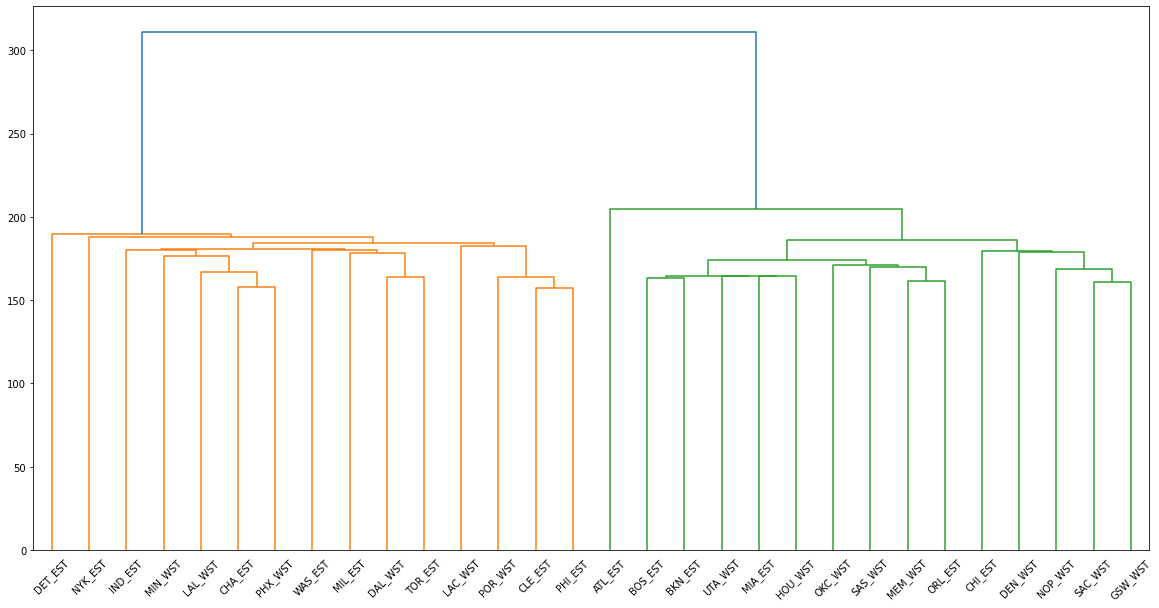

In [153]:
plt.figure(figsize=(20,10))
den = hc.dendrogram(hc.linkage(result, method='single'), orientation='top',labels=team_names)

In [162]:
p12 = pd.crosstab(NBA['PLAYER1_NAME'],NBA['PLAYER2_NAME']).fillna(0)
p13 = pd.crosstab(NBA['PLAYER1_NAME'],NBA['PLAYER3_NAME']).fillna(0)
p23 = pd.crosstab(NBA['PLAYER2_NAME'],NBA['PLAYER3_NAME']).fillna(0)

np.fill_diagonal(p12.to_numpy(), 0)
np.fill_diagonal(p13.to_numpy(), 0)
np.fill_diagonal(p23.to_numpy(), 0)


In [169]:
p13

PLAYER3_NAME,Aaron Gordon,Aaron Holiday,Abdel Nader,Al Horford,Al-Farouq Aminu,Alec Burks,Alex Abrines,Alex Caruso,Alex Len,Alex Poythress,...,Will Barton,Willie Cauley-Stein,Willy Hernangomez,Wilson Chandler,Yogi Ferrell,Yuta Watanabe,Zach Collins,Zach LaVine,Zaza Pachulia,Zhaire Smith
PLAYER1_NAME,,,,,,,,,,,,,,,,,,,,,
Aaron Gordon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aaron Holiday,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Abdel Nader,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Al Horford,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Al-Farouq Aminu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yuta Watanabe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zach Collins,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zach LaVine,0,0,0,0,1,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0


In [165]:
all_cols = p12.columns | p13.columns
x = p12.reindex(index=all_cols, columns=all_cols).fillna(0)
y = p13.reindex(index=all_cols, columns=all_cols).fillna(0)
z = x+y

all_colls2 = z.columns | p23.columns
x2 = z.reindex(index=all_cols, columns=all_cols).fillna(0)
y2 = p23.reindex(index=all_cols, columns=all_cols).fillna(0)

z+p23

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_69398/2096503263.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_cols = p12.columns | p13.columns
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_69398/2096503263.py:6: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_colls2 = z.columns | p23.columns


,Aaron Gordon,Aaron Holiday,Abdel Nader,Al Horford,Al-Farouq Aminu,Alan Williams,Alec Burks,Alex Abrines,Alex Caruso,Alex Len,...,Wilson Chandler,Yante Maten,Yogi Ferrell,Yuta Watanabe,Zach Collins,Zach LaVine,Zach Lofton,Zaza Pachulia,Zhaire Smith,Zhou Qi
Aaron Gordon,0.0,0.0,NaN,2.0,1.0,NaN,0.0,NaN,0.0,2.0,...,NaN,NaN,0.0,0.0,NaN,1.0,NaN,0.0,NaN,NaN
Aaron Holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abdel Nader,1.0,0.0,NaN,0.0,0.0,NaN,1.0,NaN,0.0,1.0,...,NaN,NaN,1.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN
Al Horford,0.0,0.0,NaN,0.0,2.0,NaN,2.0,NaN,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,0.0,NaN,1.0,NaN,NaN
Al-Farouq Aminu,1.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,0.0,0.0,NaN,0.0,2.0,NaN,2.0,NaN,0.0,5.0,...,NaN,NaN,0.0,0.0,NaN,0.0,NaN,2.0,NaN,NaN
Zach Lofton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zaza Pachulia,0.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,2.0,0.0,...,NaN,NaN,0.0,0.0,NaN,1.0,NaN,0.0,NaN,NaN
Zhaire Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
